# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up (15')

This week will require quite a lot of autonomy on your part, but we will guide you with this high-level notebook. First, take the following steps:

- Install [Poetry](https://python-poetry.org). 
- Then use Poetry to create a virtual environment:

  ```sh
  poetry install
  ```

- Then restart VS Code and add the kernel that corresponds to the environment created by Poetry.

Then, let's set up [black](https://github.com/psf/black), which is a highly encouraged best-practice for all your Python projects. That way, you never have to worry and debate about code formatting anymore. By using it, you agree to cede control over minutiae of hand-formatting. In return, Black gives you speed, determinism, and freedom from `pycodestyle` nagging about formatting. You will save time and mental energy for more important matters.

In [343]:
import jupyter_black

jupyter_black.load()

Here are the libraries you will most likely need and use during this week:

- `numpy` for basic scientific computing and `scipy` for statistical testing.
- `pandas` or `polars` for dataset manipulation. Polars is highly recommended, because it is [awesome](https://github.com/ddotta/awesome-polars). Instructions below will refer to the Polars API.
- `seaborn` for statistical data visualization, but `matplotlib` is always needed anyway. Use both!
- `shap` will be used for [interpretability](https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).
- `sklearn` and `xgboost` will be used for training models. You may import them later when you need them.

In [344]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    mutual_info_score,
    accuracy_score,
    f1_score,
    classification_report,
)
from sklearn.model_selection import train_test_split, GridSearchCV, LearningCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import shap
import matplotlib.patches as mpatches
from xgboost import XGBClassifier

## Fetch the data (15')

Here we have a very nice package that can do everything for us (aka `ucimlrepo`). Let's use it!

Take a look at [the website](https://archive.ics.uci.edu/dataset/186/wine+quality) for details.

In [345]:
from ucimlrepo import fetch_ucirepo

Fetch dataset.

In [346]:
wine_quality = fetch_ucirepo(id=186)

Parse data into pandas dataframes.

In [347]:
X = wine_quality.data.features
y = wine_quality.data.targets
# added color separate variable
color = wine_quality.data.original[["color"]]

Display metadata of the dataset.

In [348]:
wine_quality.metadata

{'uci_id': 186,
 'name': 'Wine Quality',
 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality',
 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv',
 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).',
 'area': 'Business',
 'tasks': ['Classification', 'Regression'],
 'characteristics': ['Multivariate'],
 'num_instances': 4898,
 'num_features': 11,
 'feature_types': ['Real'],
 'demographics': [],
 'target_col': ['quality'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2009,
 'last_updated': 'Wed Nov 15 2023',
 'dataset_doi': '10.24432/C56S3T',
 'creators': ['Paulo Cortez',
  'A. Cerdeira',
  'F. Almeida',
  'T. Matos',
  'J. Reis'],
 'intro_paper': {'ID': 252,
  'type': 'NATIVE',
  'ti

As we can see, there are 11 features and none require any imputation as there are no missing values.

Moreover, all the features are numerical as the are continuous variables.

Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [349]:
X.shape

(6497, 11)

In [350]:
y.shape

(6497, 1)

There are 6497 samples inside the dataset.

In [351]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
dtypes: float64(11)
memory usage: 558.5 KB


All the features are defined as `float64` programatically.

In [352]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   quality  6497 non-null   int64
dtypes: int64(1)
memory usage: 50.9 KB


In [353]:
color.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   color   6497 non-null   object
dtypes: object(1)
memory usage: 50.9+ KB


The `quality` of the wine is defined as an integer and works so but the `color` variable may be further encoded as it is a string, as of now.

In [354]:
y.value_counts()

quality
6          2836
5          2138
7          1079
4           216
8           193
3            30
9             5
Name: count, dtype: int64

As we can see, even though the `quality` features takes value in the set $[0,10]$, there are no wines whose `quality` is lower than 6 and higher than 9.

The different qualities aren't well represented as the number of wines of higher quality decreases greatly.

In [355]:
color.value_counts(normalize=True)

color
white    0.753886
red      0.246114
Name: proportion, dtype: float64

The different wine color aren't well distributed as well as there are more white wines (~75\% of the dataset) than red ones (~25\%).

## Data Exploration (1h30)

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

- Use `Dataframe.describe` to display statistics on each feature. Do the same for red wines only, and white wines only. Do you notice any clear difference?
- Compute the effect size by computing the [strictly standardized mean difference](https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference) (SSMD) between the red and white wines for each feature. 

In [356]:
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


As we can see when observing the global wine distribution, there might be outliers when considering different features as the `max` value seems to differ greatly from the distribution as it differs a lot from the 75th percentile (seen in `fixed_acidity`, `volatile_acidity`, `citric_acid`, `chlorides`, `free_sulfur_dioxide`, `total_sulfur_dioxide` and `sulphates`).

We can also visualize it.

In [357]:
plt.figure()
X.describe(percentiles=[0.5, 0.6, 0.7, 0.8, 0.9]).loc[
    ["50%", "60%", "70%", "80%", "90%", "max"]
].plot(marker="x", figsize=(10, 5))
plt.title("Features distribution on whole dataset")
plt.yscale("log")
plt.ylim((3e-2, 1e3))
plt.xlabel("Percentile")
plt.ylabel("Value [feature-specific] - log scale")

Text(0, 0.5, 'Value [feature-specific] - log scale')

The log-scale allows us to better visualize the magnitude changes in different percentiles for the variables.

We can now analyze the wine distributions per color.

In [358]:
X_color = pd.concat([X, color], axis=1)
X_color_red = X_color[X_color["color"] == "red"]
X_color_white = X_color[X_color["color"] == "white"]

In [359]:
plt.figure()
X_color_red.describe(percentiles=[0.5, 0.6, 0.7, 0.8, 0.9]).loc[
    ["50%", "60%", "70%", "80%", "90%", "max"]
].plot(marker="x", figsize=(10, 5))
plt.title("Features distribution on red wines")
plt.yscale("log")
plt.ylim((3e-2, 1e3))
plt.xlabel("Percentile")
plt.ylabel("Value [feature-specific] - log scale")

Text(0, 0.5, 'Value [feature-specific] - log scale')

Visualizing the distribution of features of red wines clearly displays a shift. The `residual_sugar` feature clearly shows that the order of magnitude of residual sugars is smaller when considering only red wines. We can also assess that the `total_sulfur_dioxide` and `free_sulfur_dioxide` are of lower magnitude.

In [360]:
plt.figure()
X_color_white.describe(percentiles=[0.5, 0.6, 0.7, 0.8, 0.9]).loc[
    ["50%", "60%", "70%", "80%", "90%", "max"]
].plot(marker="x", figsize=(10, 5))
plt.title("Features distribution on white wines")
plt.yscale("log")
plt.ylim((3e-2, 1e3))
plt.xlabel("Percentile")
plt.ylabel("Value [feature-specific] - log scale")

Text(0, 0.5, 'Value [feature-specific] - log scale')

The white wines features distribution better fits the global distribution as they are more samples of such wine inside the dataset. The distribution of red wine features are hence "drowned" when considered together with white ones.

We can now compute the effect size between red and white wines.

In [361]:
def compute_SSMD(xs1: np.array, xs2: np.array) -> float:
    """
    Compute SSMD of two features `xs1` and `xs2`.
    """

    mean_delta = xs1.mean() - xs2.mean()
    var_sum = xs1.var() + xs2.var()

    return mean_delta / np.sqrt(var_sum)

In [362]:
X_color_white.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color'],
      dtype='object')

In [363]:
features_effect_size = [
    (c, compute_SSMD(X_color_white[c], X_color_red[c]))
    for c in X_color_white.columns
    if c != "color"
]

Per definition, a smaller absolute effect size indicates a bigger similarity between two distributions. We can hence plot the absolute effect size per feature.

<Figure size 640x480 with 0 Axes>

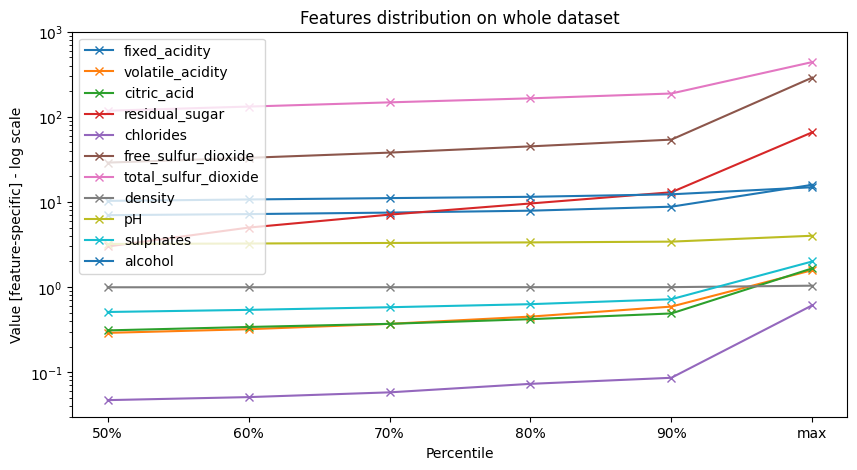

<Figure size 640x480 with 0 Axes>

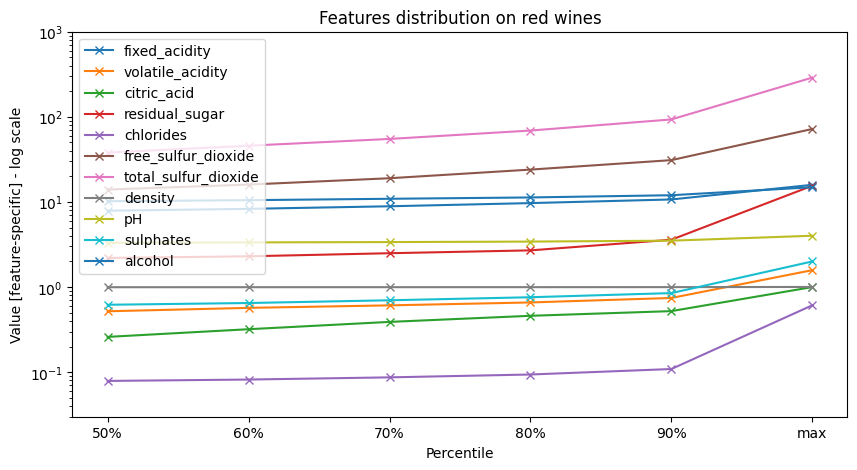

<Figure size 640x480 with 0 Axes>

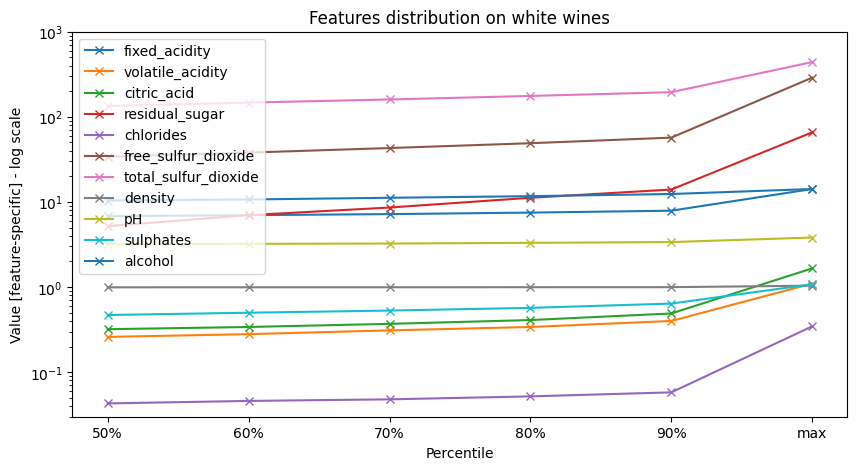

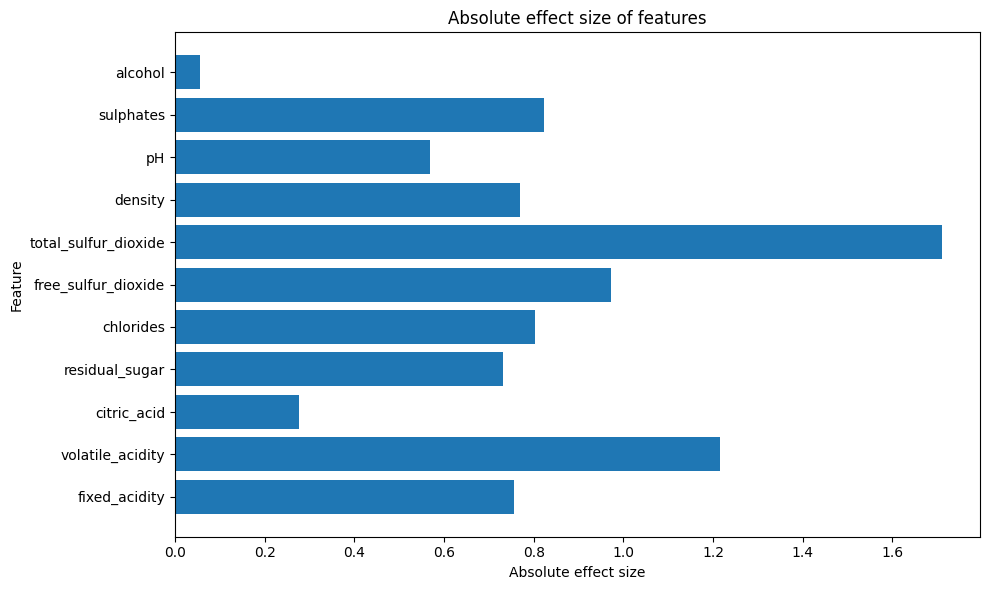

In [364]:
features = [item[0] for item in features_effect_size]
values = [abs(item[1]) for item in features_effect_size]

plt.figure(figsize=(10, 6))
plt.barh(features, values)
plt.xlabel("Absolute effect size")
plt.ylabel("Feature")
plt.title("Absolute effect size of features")
plt.tight_layout()
plt.show()

As we can see, the lowest effect size between red and white wines is the `alcohol` feature. Most interestingly, the features that might have the most predictive quality are `total_sulfur_dioxide` and `volatile_acidity`.

Now let's go a bit deeper into the same analysis, using more visual tools:

- For every feature, plot boxplots, violinplots or histograms for red and white wines. What can you infer? **If you feel a bit more adventurous**, plot the Cumulative Distribution Function (CDF) of the feature for white and red wines, and compute the [Kullback-Leibler divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) (or entropy) between them. Explain why this might be useful.
- Plot the correlation matrix of all features as heatmaps, one for red and one for white wines. How do they differ? What can you infer?

We may first display a violin plot for the red and respectively white wines.

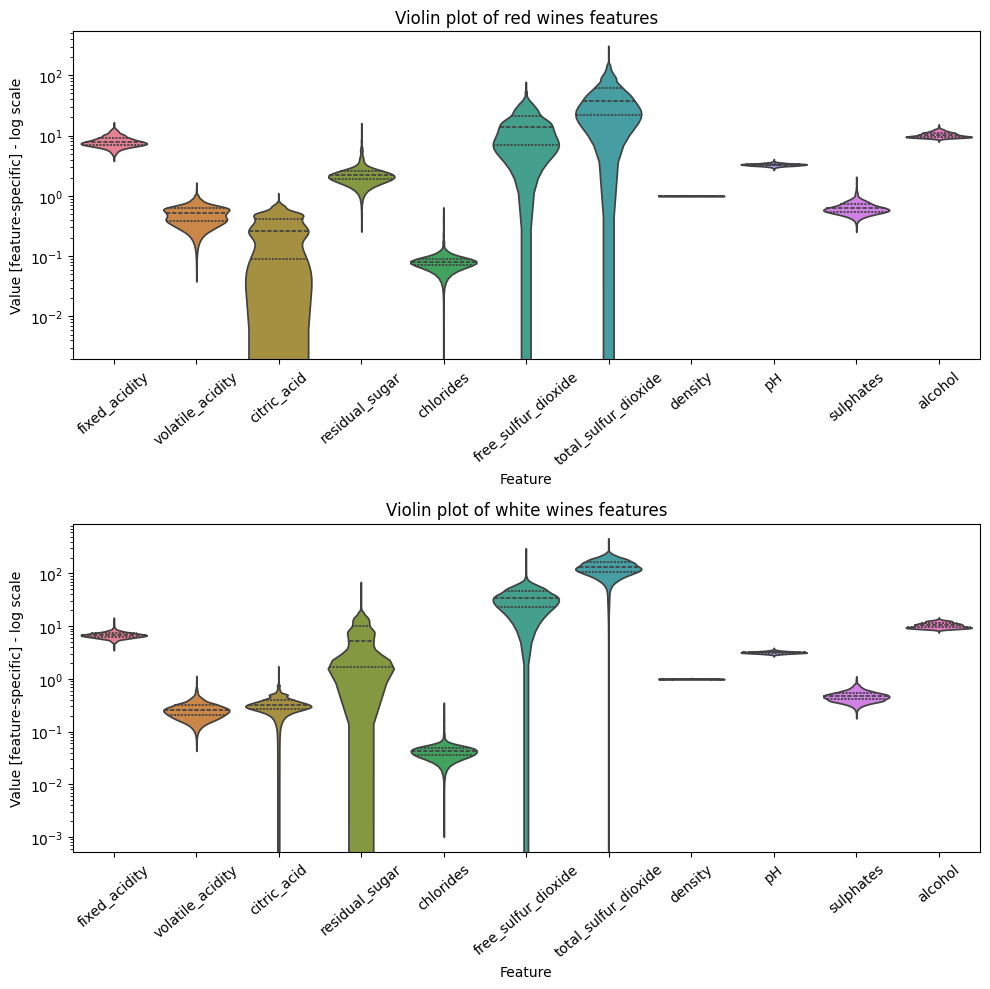

In [365]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# plot red wines
sns.violinplot(X_color_red, inner="quart", ax=axes[0])
axes[0].set_title("Violin plot of red wines features")
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Value [feature-specific] - log scale")
axes[0].set_yscale("log")
axes[0].tick_params(axis="x", rotation=40)

# plot white wines
sns.violinplot(X_color_white, inner="quart", ax=axes[1])
axes[1].set_title("Violin plot of white wines features")
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Value [feature-specific] - log scale")
axes[1].set_yscale("log")
axes[1].tick_params(axis="x", rotation=40)

plt.tight_layout()
plt.show()

The two violin plots display, per feature, their quartiles (25-50-75) and their probability density (in color). As such, we can assess key differences between red and white ones (as previously first visualized). The distribution of the continuous variable `citric_acid` is of lower magnitude in red wines. The `residual_sugar` distribution is of lower magnitude in white wines. As previously stated, the distribution of `free_sulfur_dioxide` and `total_sulfur_dioxide` is more distributed in red wines when not considering outliers.

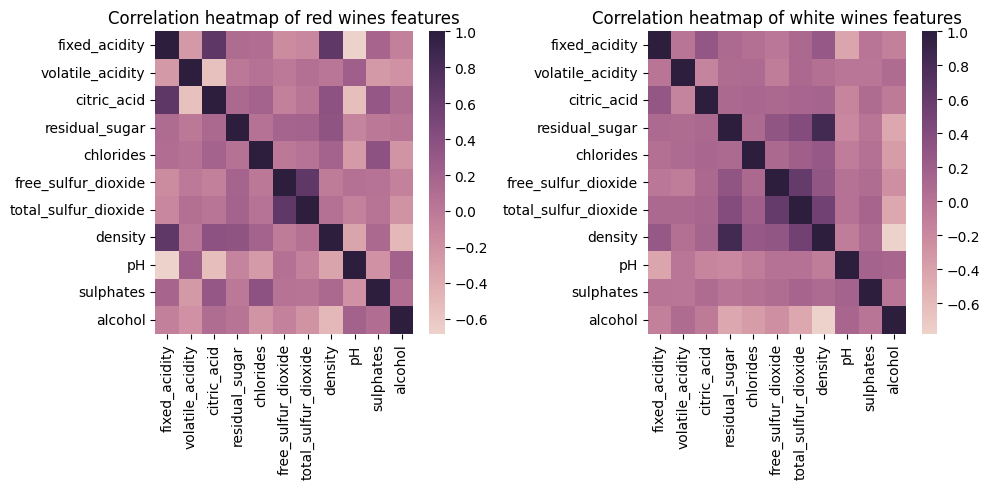

In [366]:
plt.figure(figsize=(10, 5))

# display red wines
plt.subplot(1, 2, 1)
sns.heatmap(
    X_color_red.select_dtypes(include=["float64"]).corr(),
    cmap=sns.cubehelix_palette(as_cmap=True),
)
plt.title("Correlation heatmap of red wines features")

# display white wines
plt.subplot(1, 2, 2)
sns.heatmap(
    X_color_white.select_dtypes(include=["float64"]).corr(),
    cmap=sns.cubehelix_palette(as_cmap=True),
)
plt.title("Correlation heatmap of white wines features")

plt.tight_layout()
plt.show()

As we can assess, the correlation is the greatest between `citric_acid` and `fixed_acidity`, `density` and `fixed_acidity`, `total_sulfur_dioxide` and `free_sulfur_dioxide` in red wines and between `density` and `residual_sugar` in white wines.

As such, these different correlations may indicate the predictive property of the different variables as a model may make use of it.

## Data Exploration using Unsupervised Learning (3h)

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

In [367]:
X_color_red_averaged = X_color_red.select_dtypes(include=["float64"]).agg("mean")
X_color_white_averaged = X_color_white.select_dtypes(include=["float64"]).agg("mean")

C:\Users\Dion\AppData\Local\Temp\ipykernel_18080\103545337.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


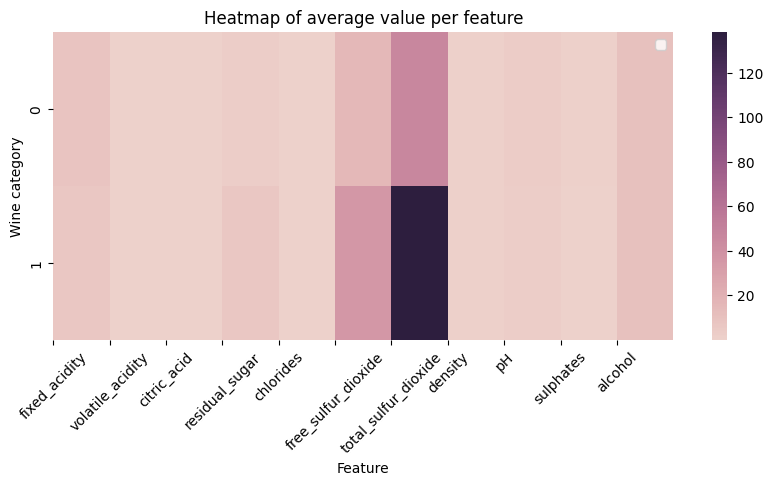

In [368]:
plt.figure(figsize=(10, 4))
sns.heatmap(
    np.vstack((X_color_red_averaged, X_color_white_averaged)),
    cmap=sns.cubehelix_palette(as_cmap=True),
)
plt.xlabel("Feature")
plt.ylabel("Wine category")
plt.xticks(
    ticks=np.arange(len(X_color_red_averaged.index)),
    labels=X_color_red_averaged.index.array,
    rotation=45,
)
plt.title("Heatmap of average value per feature")
plt.legend()
plt.show()

We may say that red wines have a greater `free_sulfur_dioxide` than white wines and so goes on with the `total_sulfur_dioxide` (consequence).

### Using PCA to reduce the dimensionality

Use PCA to reduce the dimensionality of data. Do not forget that it requires data normalization (centering on the mean and scaling to unit variance). Plot the whole dataset onto the two principal components and color it by wine color. What does it tell you?

Project the unit vectors that correspond to each vector onto the principal components, using the same transformation. What does it tell you about the relative feature importance? Does it match the observations you made previously?

We may first standardize the different features.

In [369]:
standard_scaler = StandardScaler().set_output(transform="pandas")

In [370]:
X_standardized = standard_scaler.fit_transform(X)

In [371]:
X_standardized.describe().loc[["mean", "std"]]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
mean,-3.849639e-16,1.049902e-16,2.187295e-17,3.499672e-17,1.749836e-17,-8.749179e-17,-6.999344e-17,-3.552167e-15,2.729744e-15,-5.424491e-16,6.561885e-16
std,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00


As we can notice, the different features are standardized as the mean $\mu=0$ and standard deviation is $\sigma=1$.

We may now go on and apply and then display a PCA on the data.

In [372]:
pca_2 = PCA(n_components=2, random_state=42).set_output(transform="pandas")

In [373]:
# attention, must do PCA on whole
# dataset and then split on color
# to keep distributions intact
X_pca = pca_2.fit_transform(X_standardized)

In [374]:
X_color_red_pca = pd.concat([X_pca, color], axis=1)
X_color_red_pca = X_color_red_pca[X_color_red_pca["color"] == "red"].drop(
    columns=["color"]
)

In [375]:
X_color_white_pca = pd.concat([X_pca, color], axis=1)
X_color_white_pca = X_color_white_pca[X_color_white_pca["color"] == "white"].drop(
    columns=["color"]
)

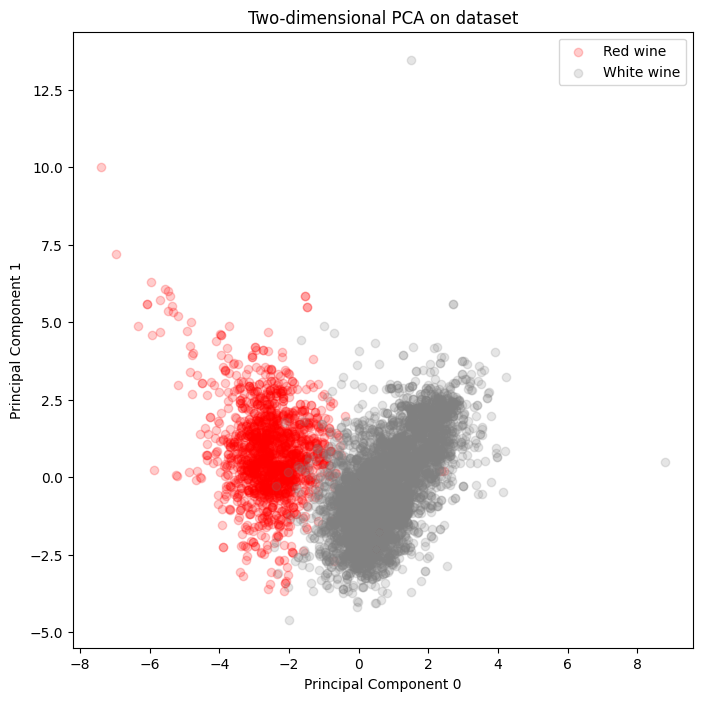

In [376]:
plt.figure(figsize=(8, 8))

plt.scatter(
    X_color_red_pca[["pca0"]],
    X_color_red_pca[["pca1"]],
    color="red",
    alpha=0.2,
    label="Red wine",
)
plt.scatter(
    X_color_white_pca[["pca0"]],
    X_color_white_pca[["pca1"]],
    color="gray",
    alpha=0.2,
    label="White wine",
)

plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.legend()
plt.title("Two-dimensional PCA on dataset")
plt.show()

As we can notice, reducing the data to a two-dimensional plane yields visual difference between red and white wine.

We can now display the different unit vectors that compose the higher-dimensional space by projecting them onto our plane.

In [377]:
# multiply by sqrt(variance) := std
loadings = pca_2.components_.T * np.sqrt(pca_2.explained_variance_ratio_) * 20

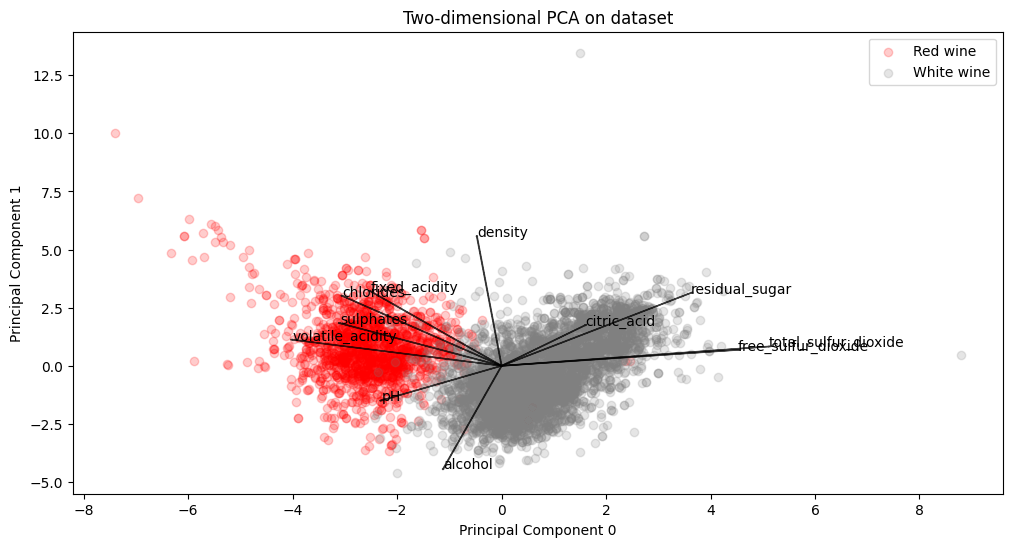

In [378]:
plt.figure(figsize=(12, 6))

plt.scatter(
    X_color_red_pca[["pca0"]],
    X_color_red_pca[["pca1"]],
    color="red",
    alpha=0.2,
    label="Red wine",
)
plt.scatter(
    X_color_white_pca[["pca0"]],
    X_color_white_pca[["pca1"]],
    color="gray",
    alpha=0.2,
    label="White wine",
)

for index, feature in enumerate(X.columns):
    plt.annotate(feature, (loadings[index, 0], loadings[index, 1]), color="black")

    plt.arrow(
        0,
        0,
        loadings[index, 0],
        loadings[index, 1],
        color="black",
        alpha=0.7,
        width=0.01,
    )


plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.legend()
plt.title("Two-dimensional PCA on dataset")
plt.show()

Displaying the projected components allows to visualize the most contributing axes when projecting into the plane (`free_sulfur_dioxide` and `total_sulfur_dioxide`).

### Cluster the data in 2-dimensional space

Use k-means to cluster the data into 2 clusters and plot the same view as before, but with a coloring that corresponds to the cluster memberships.

Assuming that the cluster assignments are predictions of a model, what is the performance you can achieve in terms of mutual information score, accuracy, and f1 score?

In [379]:
color_encoded = [0 if c == "red" else 1 for _, c in color["color"].items()]
kmeans = KMeans(n_clusters=2, random_state=42)

In [380]:
y_clustered_11 = kmeans.fit_predict(X)
y_clustered_2 = kmeans.fit_predict(X_pca)

In [381]:
def print_metrics(y_true, y_pred):
    print(f"Mutual Information Score -> {mutual_info_score(y_true, y_pred)}")
    print(f"Accuracy Score -> {accuracy_score(y_true, y_pred)}")
    print(f"F1-Score -> {f1_score(y_true, y_pred)}")

In [382]:
print("Indicators on clustering of high-dimensional data :")
print_metrics(np.ravel(color_encoded), y_clustered_11)

Indicators on clustering of high-dimensional data :
Mutual Information Score -> 0.19652932172065912
Accuracy Score -> 0.7854394335847315
F1-Score -> 0.8373015873015873


In [383]:
print("Indicators on clustering of high-dimensional data :")
print_metrics(np.ravel(color_encoded), y_clustered_2)

Indicators on clustering of high-dimensional data :
Mutual Information Score -> 0.480717971115607
Accuracy Score -> 0.9827612744343543
F1-Score -> 0.9884986650236188


As we can see, the indicators show greater performance when clustering the already plane-projected data. We can now display it to assess wether it clustered on wine color of other underlying properties.

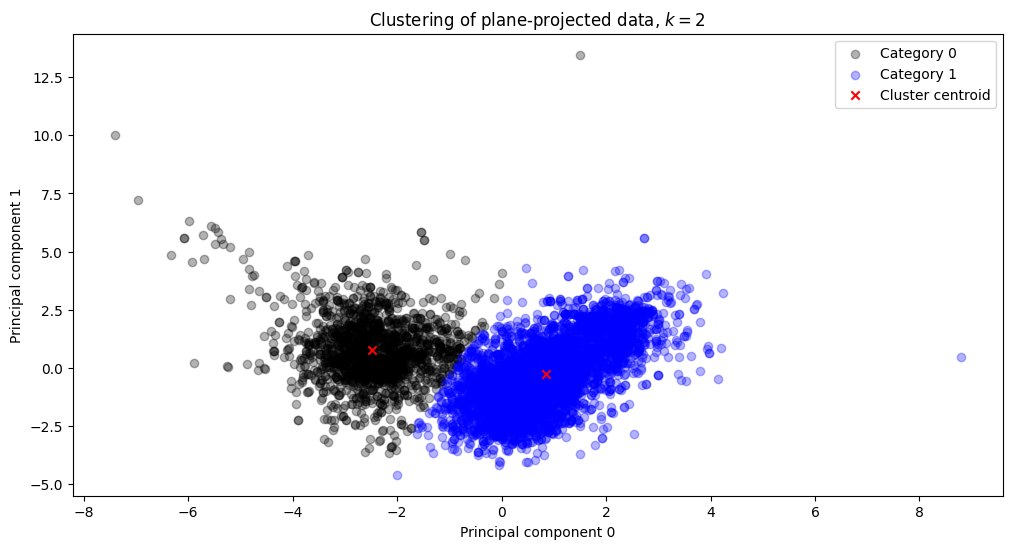

In [384]:
X_pca_cluster_0 = X_pca[kmeans.labels_ == 0]
X_pca_cluster_1 = X_pca[kmeans.labels_ == 1]

plt.figure(figsize=(12, 6))

plt.scatter(
    X_pca_cluster_0[["pca0"]],
    X_pca_cluster_0[["pca1"]],
    color="black",
    alpha=0.3,
    label="Category 0",
)
plt.scatter(
    X_pca_cluster_1[["pca0"]],
    X_pca_cluster_1[["pca1"]],
    color="blue",
    alpha=0.3,
    label="Category 1",
)
plt.scatter(
    kmeans.cluster_centers_[0, 0],
    kmeans.cluster_centers_[0, 1],
    color="red",
    marker="x",
)
plt.scatter(
    kmeans.cluster_centers_[1, 0],
    kmeans.cluster_centers_[1, 1],
    color="red",
    marker="x",
    label="Cluster centroid",
)
plt.title("Clustering of plane-projected data, $k=2$")
plt.xlabel("Principal component 0")
plt.ylabel("Principal component 1")
plt.legend()

plt.show()

`KMeans` seems to have clustered by color based on the graph.

Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.

- Set up a train/test dataset using `sklearn.model_selection.train_test_split`.
- Use `GridSearchCV` to perform a cross-validation of the model's regularization `C`.
- Compare the test and train performance at the end. Does the model suffer from any overfitting? 
- Analyze the test performance specifically. What can you conclude about this general problem of recognizing white vs red wines?

We must first encode the output labels so that the logistic regression is possible.

In [385]:
label_encoder = LabelEncoder()

In [386]:
color_encoded = label_encoder.fit_transform(color["color"])

The splitting of the data will be done with stratifying to make sure that the distribution of the training labels is the same (in terms of balance) as the one of the training split.

In [387]:
X_train, X_test, y_train, y_test = train_test_split(
    X, color_encoded, train_size=0.8, stratify=color_encoded
)

We must now standardize the different features so that the distributions in training and testing set are comparable.

In [388]:
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [389]:
X_train.describe().loc[["mean", "std"]].agg("mean", axis=1)

mean   -2.199697e-15
std     1.000096e+00
dtype: float64

In [390]:
X_test.describe().loc[["mean", "std"]].agg("mean", axis=1)

mean    0.005266
std     1.028069
dtype: float64

As we can see, the numerical features of the training and testing split are normalized.

In [391]:
logistic_regression = GridSearchCV(
    LogisticRegression(max_iter=10000, random_state=42),
    param_grid={"C": list(map(lambda _: np.random.rand() * 10, range(0, 50)))},
    scoring="accuracy",
    n_jobs=-1,
)

In [392]:
logistic_regression.fit(X_train, np.ravel(y_train))

GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.5024566313830836, 9.709324630954745,
                               0.5048199408253373, 4.814534177522001,
                               3.9734340250774913, 9.313452401088465,
                               7.1649457932533664, 6.719485069279722,
                               1.0923666579264768, 8.501833949544293,
                               0.5801124186709294, 9.546042132805962,
                               7.735514213265021, 1.489352962102547,
                               6.846138624891954, 9.480305593790957,
                               8.810050669227268, 8.739529492998823,
                               2.3155646385052853, 3.060713830749976,
                               3.79039705682605, 2.8815891731450103,
                               7.05125403423748, 2.323433129432555,
                               6.504278465611883, 1.5310177480181486,
                               1.5422688517612826, 2.8560004331357893,
                               9.855830342767199, 4.707544575308123, ...]},
             scoring='accuracy')

In [393]:
logistic_regression = logistic_regression.best_estimator_

In [394]:
y_train_predicted = logistic_regression.predict(X_train)
y_test_predicted = logistic_regression.predict(X_test)

In [395]:
print("Performance on training split :")
print_metrics(np.ravel(y_train), y_train_predicted)

Performance on training split :
Mutual Information Score -> 0.5258367118899412
Accuracy Score -> 0.9948046950163556
F1-Score -> 0.9965565616630532


In [396]:
print("Performance on testing split :")
print_metrics(np.ravel(y_test), y_test_predicted)

Performance on testing split :
Mutual Information Score -> 0.5173983504254612
Accuracy Score -> 0.9930769230769231
F1-Score -> 0.9954105048444671


At first glance, the accuracy score on testing split is greater than the one computed on training split. It may indicate good fitting quality. We can assess it by displaying a learning curve.

<Figure size 640x480 with 0 Axes>

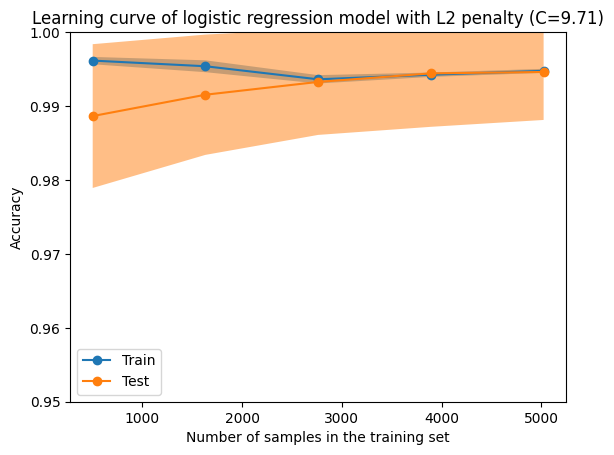

In [397]:
plt.figure()
LearningCurveDisplay.from_estimator(
    logistic_regression,
    X_train,
    y_train,
    scoring="accuracy",
    score_name="Accuracy",
    line_kw={"marker": "o"},
    cv=30,
    n_jobs=-1,
)
plt.title(
    f"Learning curve of logistic regression model with L2 penalty (C={logistic_regression.C:.3})"
)
plt.ylim((0.95, 1))
plt.show()

The learning curve helps us to assess the great fitting quality. We can now look into the details of the training split predictions performance.

In [398]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       320
           1       0.99      1.00      1.00       980

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



As we can see, the distribution of the testing split is stratified from the distribution of the training split (75-25 between red and white wines). We can conclude from this matrix that the model is better able to predict the white wines (by an unsignificant difference).

### Basic model interpretability: inspecting the model

As a first step towards intepretability of the model predictions, let's take a look at the coefficients of the model. What is the most important feature from this perspective? How do you interpret positive or negative coefficients?

Is it compatible with what you have seen so far? Do you have an explanation why that might be?

In [399]:
logistic_regression.coef_

array([[ 0.27344708, -1.24355912,  0.21415593,  5.06550102, -0.87352512,
        -1.28809912,  2.93781012, -4.88606535,  0.06730061, -0.54130159,
        -1.948214  ]])

Considering the fact that the model is linear and predicts the logarithm of the odds of having said target, the odds can be expressed as the exponential of the coefficients $\beta_i$. Hence, a positive coefficient indicates that a growth in said direction increases the odds of the outcome happenning (multiplies by $e^\beta$), reciprocal being true.

Hence, a negative coefficient multiplies the odds of said outcome by $\frac{1}{e^\beta}$ which barely accounts for any ratio of said outcome happening.

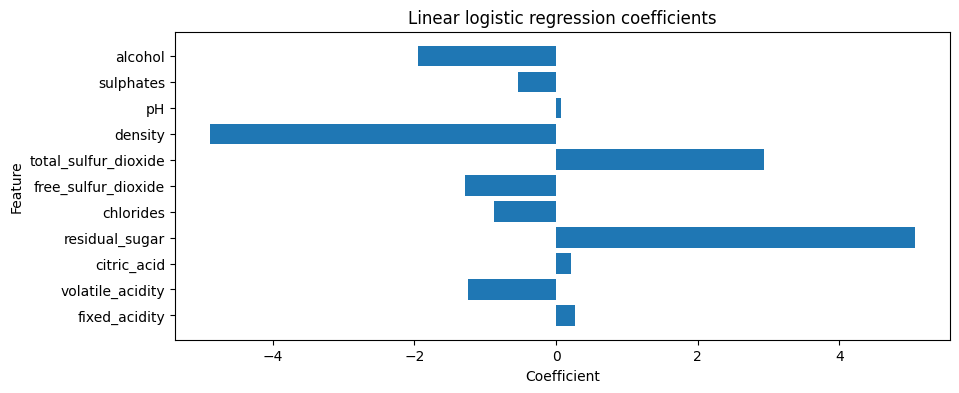

In [400]:
coefficients = logistic_regression.coef_.flatten()

plt.figure(figsize=(10, 4))
plt.barh(X_train.columns, coefficients)

plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Linear logistic regression coefficients")

plt.show()

As such, we can display the features whose coefficient is positive. The `citric_acid` and `total_sulfur_dioxide` features distribution shift from a wine color to another, for example, was clearly visible in the violin plot.

### Removing features to test their importance

- What happens if you re-train a model, but remove the most important feature in the list?
- What happens if you re-train the model with a `l1` penalty and you use more regularization? 
- Interpret the results you obtained above from the perspective of the business problem. What does it tell you about the key differences between a red and white wine?

In [401]:
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X.drop(columns=["residual_sugar"]),
    color_encoded,
    train_size=0.8,
    stratify=color_encoded,
)

We can first standardize the different features.

In [402]:
X_train_reduced = standard_scaler.fit_transform(X_train_reduced)
X_test_reduced = standard_scaler.transform(X_test_reduced)

We can now train the model by assessing quality of accuracy on different L1 penalty parameter value. For this matter, the `liblinear` optimization solving algorithm will be used as it supports L1 penalty. Only stronger regularization than the one determined by the previous `GridSearch` will be tested. 

In [403]:
logistic_regression_l1 = GridSearchCV(
    LogisticRegression(
        max_iter=10000, random_state=42, solver="liblinear", penalty="l1"
    ),
    param_grid={"C": list(map(lambda _: np.random.rand() * 5, range(0, 50)))},
    scoring="accuracy",
    n_jobs=-1,
)

In [404]:
logistic_regression_l1.fit(X_train_reduced, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                          random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [2.316770178896606, 4.754015161143341,
                               0.7812569761997429, 0.6547592404635616,
                               3.3485189332687226, 0.04638637130120804,
                               3.4738318245803472, 4.244606887039176,
                               0.6696003203629897, 0.5363277671229544,
                               4.624809774422736, 2.006585407...
                               3.488993488440584, 2.405130663523327,
                               2.5205856494323604, 1.4014442585825782,
                               0.6076193852569822, 2.8384657090105767,
                               0.9780506478116602, 2.612935882039716,
                               4.336498707308352, 1.9757404329721644,
                               2.9209941244853455, 2.170795170098333,
                               2.9078847231948886, 1.7221890180391164,
                               2.004280527177613, 0.11567368708207404,
                               2.1426344647798166, 0.8944139667977563, ...]},
             scoring='accuracy')

In [405]:
logistic_regression_l1 = logistic_regression_l1.best_estimator_

In [406]:
y_train_reduced_predicted = logistic_regression_l1.predict(X_train_reduced)
y_test_reduced_predicted = logistic_regression_l1.predict(X_test_reduced)

In [407]:
print("Performance on training split :")
print_metrics(y_train, y_train_reduced_predicted)

Performance on training split :
Mutual Information Score -> 0.5032784261655011
Accuracy Score -> 0.990186646142005
F1-Score -> 0.9935023569881514


In [408]:
print("Performance on testing split :")
print_metrics(y_test, y_test_reduced_predicted)

Performance on testing split :
Mutual Information Score -> 0.5056357824472039
Accuracy Score -> 0.9907692307692307
F1-Score -> 0.9938962360122076


In [409]:
print(classification_report(y_test, y_test_reduced_predicted))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       320
           1       0.99      1.00      0.99       980

    accuracy                           0.99      1300
   macro avg       0.99      0.98      0.99      1300
weighted avg       0.99      0.99      0.99      1300



The different metrics, again, indicate greater performance of the model on testing split. We must now assess the fitting quality with multiple folds. The performance of the model, overall, is lower (by a negligeable amount).

<Figure size 640x480 with 0 Axes>

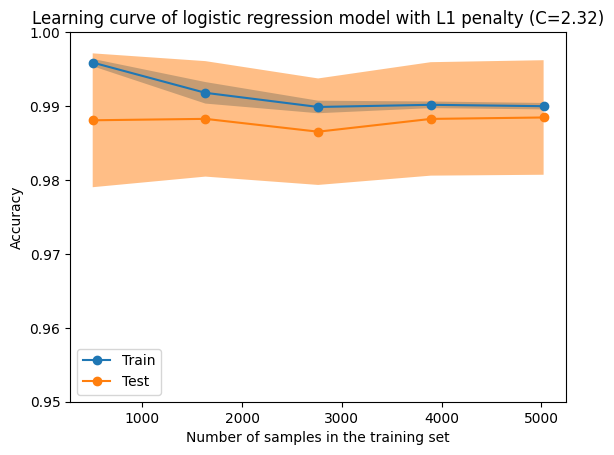

In [410]:
plt.figure()
LearningCurveDisplay.from_estimator(
    logistic_regression_l1,
    X_train_reduced,
    y_train,
    scoring="accuracy",
    score_name="Accuracy",
    line_kw={"marker": "o"},
    cv=30,
    n_jobs=-1,
)
plt.title(
    f"Learning curve of logistic regression model with L1 penalty (C={logistic_regression_l1.C:.3})"
)
plt.ylim((0.95, 1))
plt.show()

As we can see, the accuracy on training split seems to be better than the one computed on the testing split. However, the variance of the accuracy metric on testing split is greater. We can hence consider that the fitting quality is great.

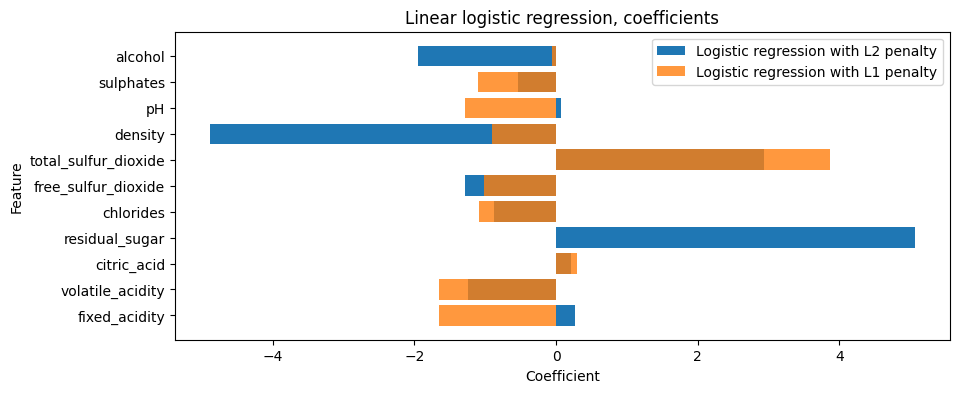

In [411]:
coefficients_l2 = logistic_regression.coef_.flatten()
coefficients_l1 = logistic_regression_l1.coef_.flatten()

plt.figure(figsize=(10, 4))
plt.barh(
    X_train.columns,
    coefficients_l2,
    label="Logistic regression with L2 penalty",
)
plt.barh(
    X_train_reduced.columns,
    coefficients_l1,
    alpha=0.8,
    label="Logistic regression with L1 penalty",
)

plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Linear logistic regression, coefficients")
plt.legend()

plt.show()

As we now notice, the greatest coefficient in the new model is the `total_sulfur_dioxide` feature ; the feature that previously ranked 2nd in the features coefficients ranking from greatest to smallest. In contrario, some features now have a greater coefficient (`density` for eg.).

In terms of business, it indicates us that the greatest features' coefficients indicate a bigger odds ratio and hence better help distinct red wines from white ones. Those features are mostly `residual_sugar` and `total_sulfur_dioxide`.

### Using Shapley values

Now, use SHAP to explore how the model perceives a 'red' and 'white' wine.

- Use a `beeswarm` plot to analyze the influence of each feature on the model's output.
- What does the plot tell us about what makes a white wine 'white' and a red wine 'red'?

In [412]:
explainer = shap.Explainer(logistic_regression, X_train)
shap_values_logistic_regression = explainer(X_train)

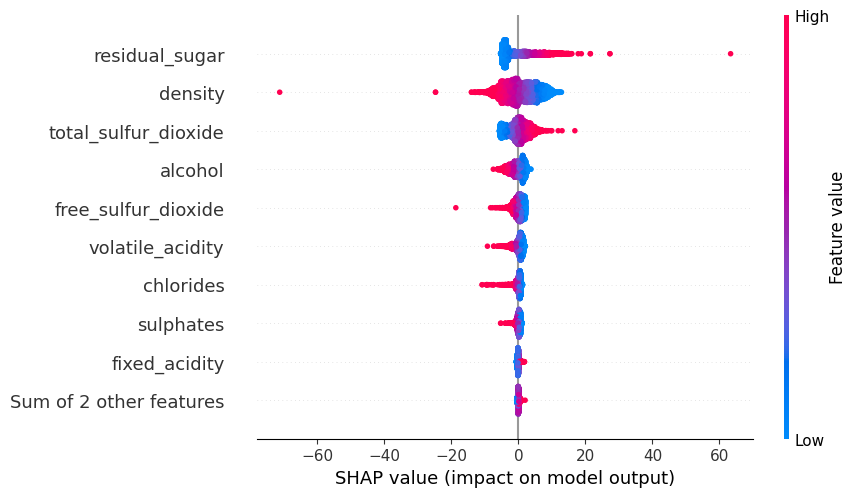

In [413]:
shap.plots.beeswarm(shap_values_logistic_regression)

The plot shows that as certain features value increases respectively decreases, it has a certain impat on the model's output. The `residual_sugar` feature, for eg., has a bigger impact on model output as it increases whereas the `density` feature acts the other way around.

The positive impact indicates that when said feature increases respectively decreases, it has a greater impact (hence decision between red and white wine) output.

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.

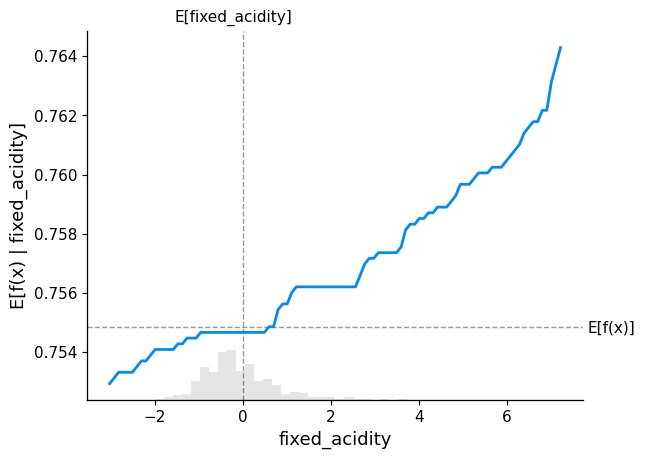

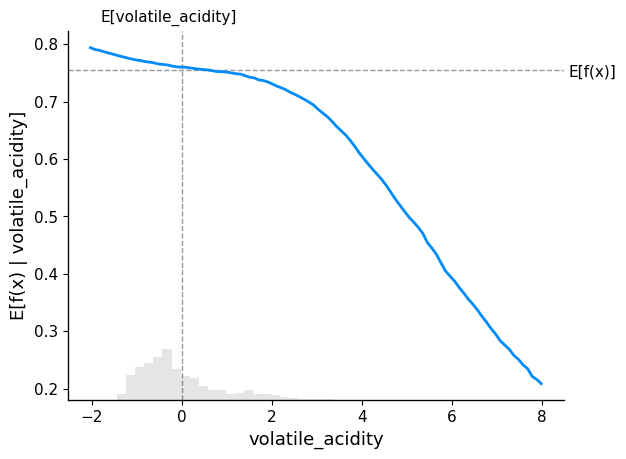

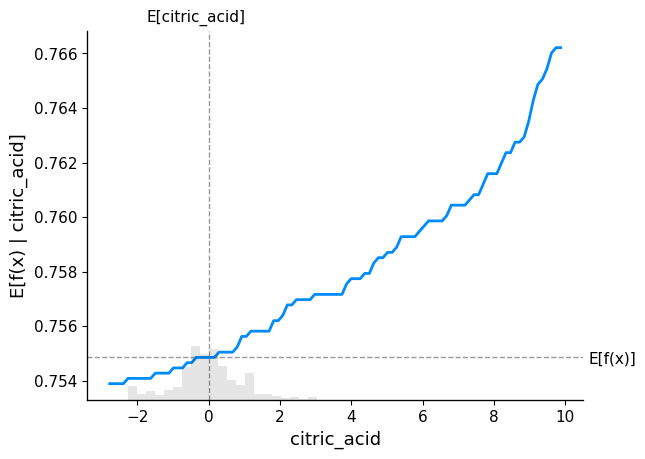

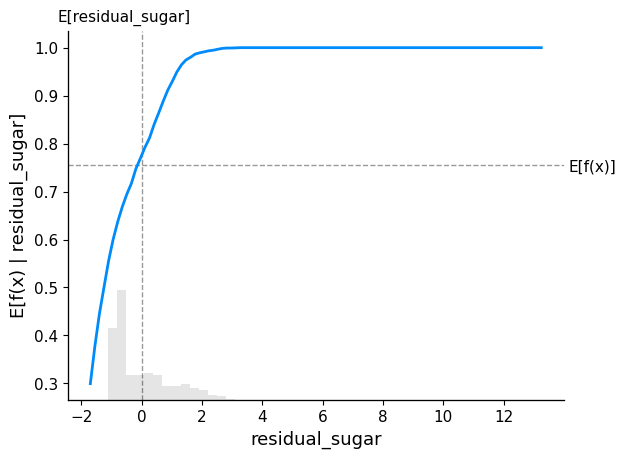

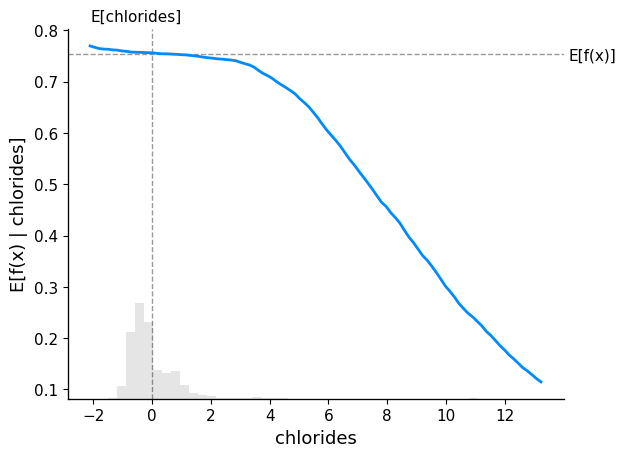

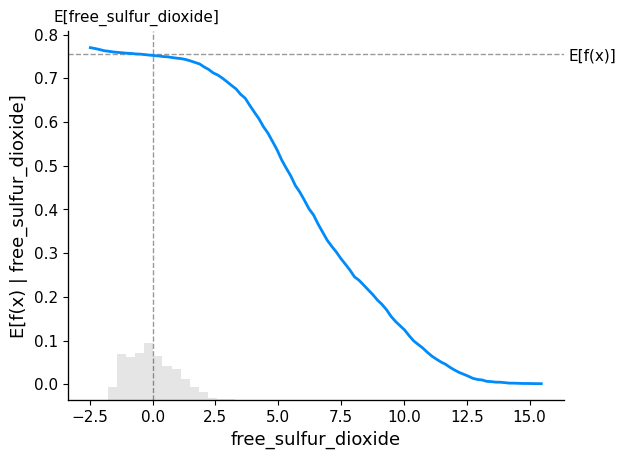

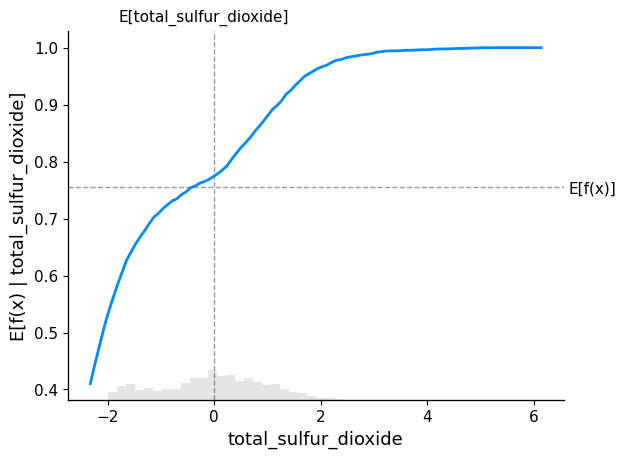

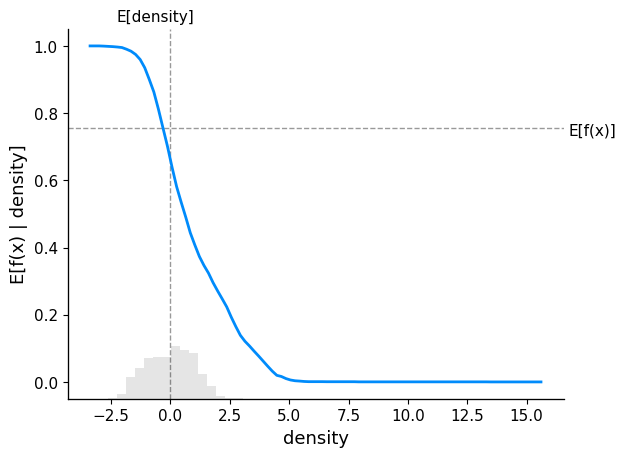

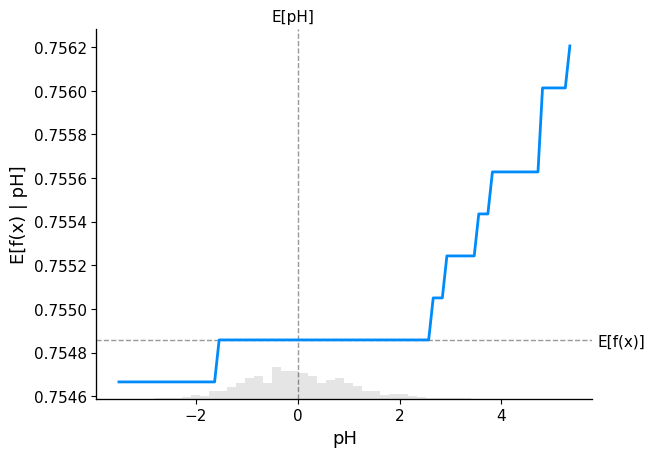

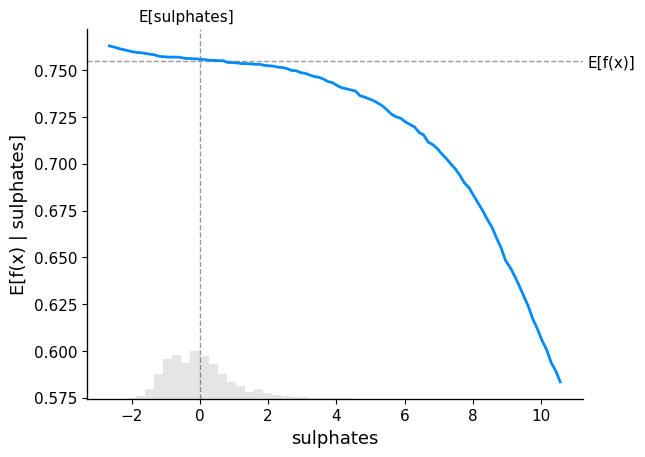

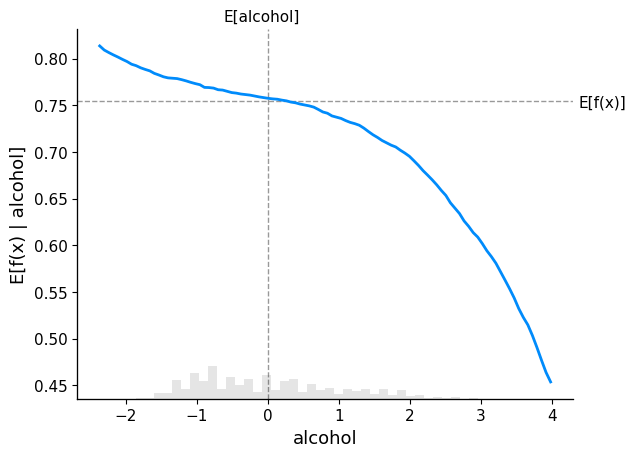

In [414]:
for column in X_train.columns:
    shap.partial_dependence_plot(
        column,
        logistic_regression.predict,
        X_train,
        ice=False,  # when said feature is related to other features
        model_expected_value=True,
        feature_expected_value=True,
    )

The different partial dependence plots display the model's output expectancy when changing the value of said feature.

- Now use a waterfall diagram on a specific red and white wine and see how the model has made this specific prediction. 

In [434]:
print(label_encoder.inverse_transform(y_test[:3]))
print(label_encoder.inverse_transform(y_test_reduced_predicted[:3]))

['white' 'red' 'white']
['white' 'red' 'white']


As we can see, the samples 0 and 1 of the testing split were both accurately predicted to respectively white and red. We can hence use them as specific samples.

In [437]:
explainer = shap.Explainer(logistic_regression_l1, X_test_reduced)
shap_values_logistic_regression_l1 = explainer(X_test_reduced)

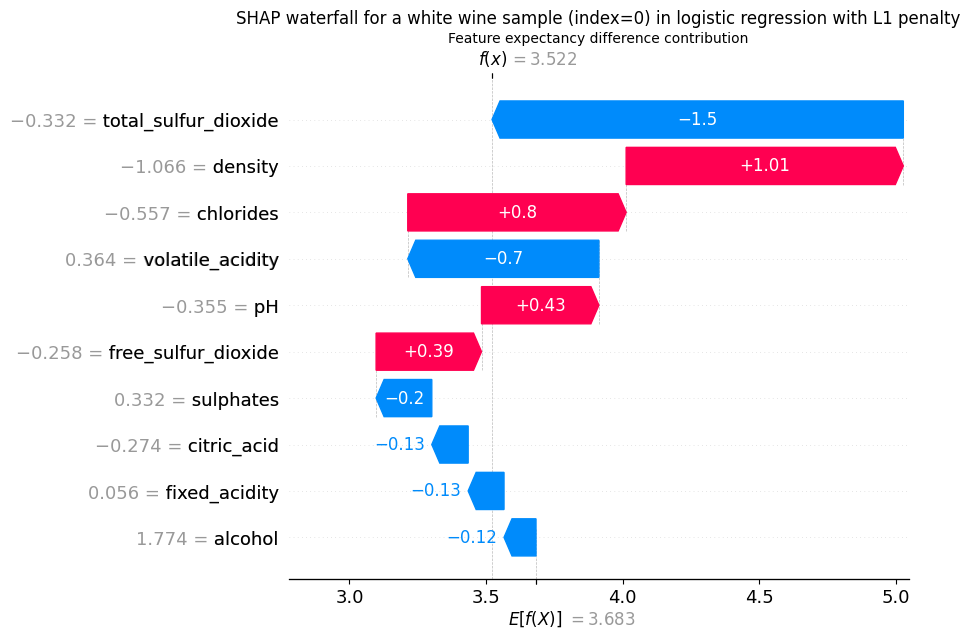

In [438]:
plt.figure()
shap.plots.waterfall(shap_values_logistic_regression_l1[0], show=False)
plt.title(
    "SHAP waterfall for a white wine sample (index=0) in logistic regression with L1 penalty"
)
plt.xlabel("Feature expectancy difference contribution")
plt.show()

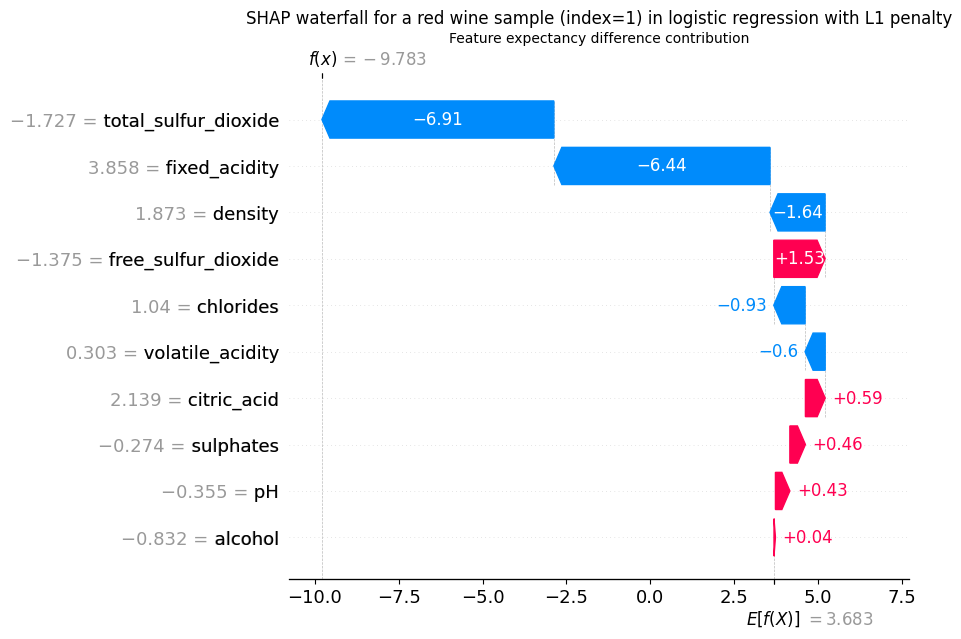

In [440]:
plt.figure()
shap.plots.waterfall(shap_values_logistic_regression_l1[1], show=False)
plt.title(
    "SHAP waterfall for a red wine sample (index=1) in logistic regression with L1 penalty"
)
plt.xlabel("Feature expectancy difference contribution")
plt.show()

As we can see, in both cases, the `total_sulfur_dioxide` greatly contributed to make the prediction of the model differ from its expectancy. The `pH` feature when considering the white wine sample clearly shifted towards a `red` prediction as it did too in the red wine sample. In the red wine sample, the value of the `total_sulfur_dioxide` feature greatly contributed to predict the wine being red as its value greatly differs from the distribution of the white wines one.

- Now, let's take an example where the model has made an incorrect prediction, and see how it made this prediction.

In [442]:
falsely_predicted_index = 0
for index in range(y_test.shape[0]):
    if y_test[index] != y_test_reduced_predicted[index]:
        print(f"Sample index whose color is incorrectly predicted -> {index}")
        print(
            f"True: {label_encoder.inverse_transform(y_test[[index]])}, Predicted: {label_encoder.inverse_transform(y_test_reduced_predicted[[index]])}"
        )
        falsely_predicted_index = index
        break

Sample index whose color is incorrectly predicted -> 98
True: ['red'], Predicted: ['white']


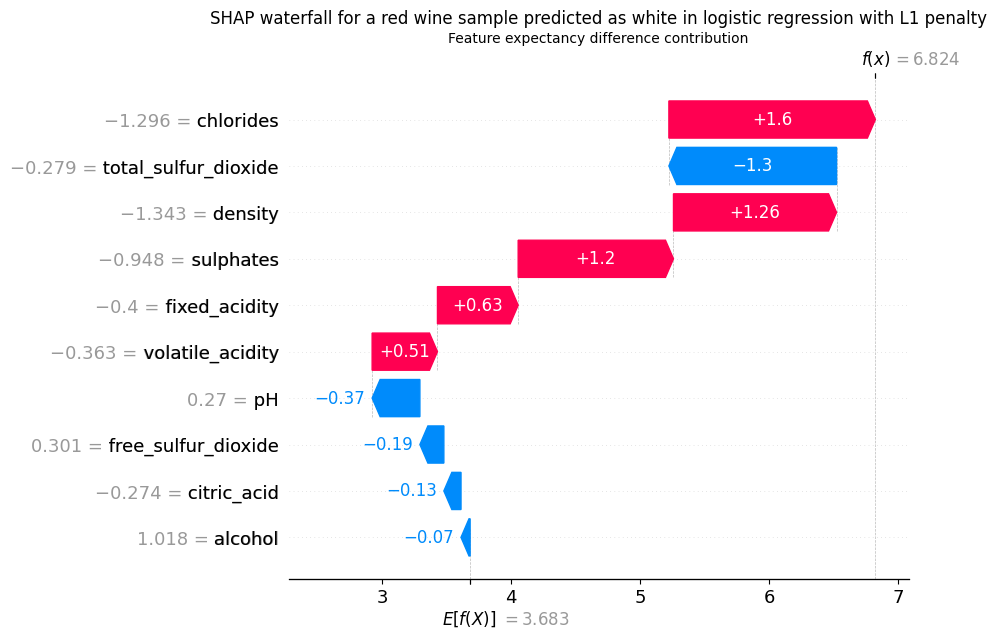

In [443]:
plt.figure()
shap.plots.waterfall(
    shap_values_logistic_regression_l1[falsely_predicted_index], show=False
)
plt.title(
    "SHAP waterfall for a red wine sample predicted as white in logistic regression with L1 penalty"
)
plt.xlabel("Feature expectancy difference contribution")
plt.show()

As we can see, the `total_sulfur_dioxide` feature which previously greatly contributed to predict the color of the wine being red whereas it doesn't have this much of an effect on this sample. Other features such as `density`, `chlorides` and `sulphates` for eg. contributed to this false prediction.

# Good vs Bad classification (3h)

We are going to work on a binary classification problem, where all wines with a quality higher than 6 are considered as "good" and other are considered as "bad".  

- Prepare a dataset with a new column `binary_quality` that corresponds to the above definition.

One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 

Ideally, there should be almost none. Why could it be a problem otherwise?

In [304]:
binary_quality = pd.DataFrame(y["quality"].apply(lambda x: "good" if x > 6 else "bad"))

To compute correlation between both series, we need to first encode them.

In [305]:
one_hot_encoder_binary_quality = OneHotEncoder(sparse_output=False).set_output(
    transform="pandas"
)
binary_quality_encoded = one_hot_encoder_binary_quality.fit_transform(binary_quality)

In [306]:
one_hot_encoder_binary_color = OneHotEncoder(sparse_output=False).set_output(
    transform="pandas"
)
binary_color = one_hot_encoder_binary_color.fit_transform(color)

In [307]:
X_color_quality = pd.concat([X, binary_quality_encoded, binary_color], axis=1)

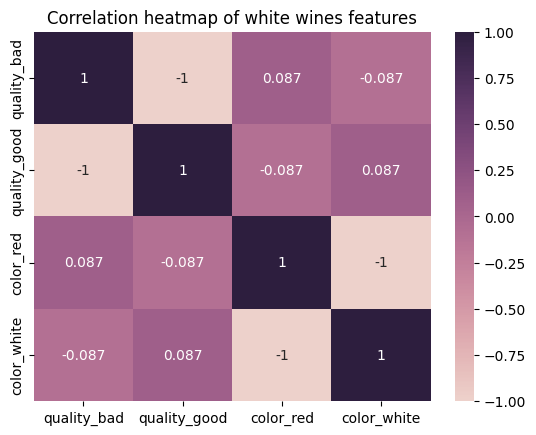

In [308]:
plt.figure()
sns.heatmap(
    X_color_quality[["quality_bad", "quality_good", "color_red", "color_white"]].corr(),
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot=True,
)
plt.title("Correlation heatmap of white wines features")
plt.show()

As seen on the heatmap, the correlation between a good wine and white wines is positively correlated while a bad wine quality is positively correlated with red wines. The correlation being so small, we can assume that the color of a wine hasn't any predictive impact on its quality, by itself at least. If it were to be so, one could simply tell if a wine is of good quality by assessing its color.

If it turns out that there are significantly more bad red wines than bad white wines or vice versa, what are the implications for your analysis?

- Plot a heatmap of the mean feature value for bad and good wines, like we did before for red and white wines.
- Plot two heatmaps, one for red and white wines. How do they differ? What kind of issue can it cause?

In [309]:
X_color_quality_good = X_color_quality[X_color_quality["quality_good"] == 1.0].drop(
    columns=["quality_good", "quality_bad", "color_red", "color_white"]
)
X_color_quality_bad = X_color_quality[X_color_quality["quality_good"] == 0.0].drop(
    columns=["quality_good", "quality_bad", "color_red", "color_white"]
)

In [310]:
X_color_quality_good_averaged = X_color_quality_good.select_dtypes(
    include=["float64"]
).agg("mean")
X_color_quality_bad_averaged = X_color_quality_bad.select_dtypes(
    include=["float64"]
).agg("mean")

In [311]:
X_color_quality_red = X_color_quality[X_color_quality["color_red"] == 1.0].drop(
    columns=["quality_good", "quality_bad", "color_red", "color_white"]
)
X_color_quality_white = X_color_quality[X_color_quality["color_red"] == 0.0].drop(
    columns=["quality_good", "quality_bad", "color_red", "color_white"]
)

In [312]:
X_color_quality_red_averaged = X_color_quality_red.select_dtypes(
    include=["float64"]
).agg("mean")
X_color_quality_white_averaged = X_color_quality_white.select_dtypes(
    include=["float64"]
).agg("mean")

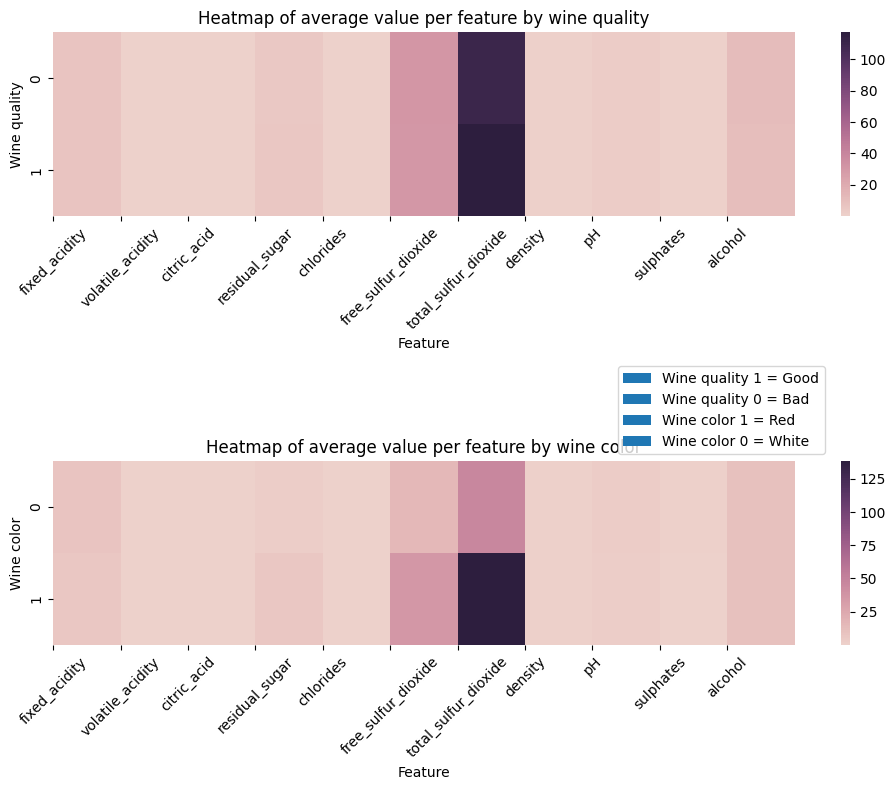

In [313]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.heatmap(
    np.vstack((X_color_quality_good_averaged, X_color_quality_bad_averaged)),
    cmap=sns.cubehelix_palette(as_cmap=True),
    ax=axes[0],
)
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Wine quality")
axes[0].set_xticks(np.arange(len(X_color_quality_good_averaged.index)))
axes[0].set_xticklabels(X_color_quality_good_averaged.index.array, rotation=45)
axes[0].set_title("Heatmap of average value per feature by wine quality")

sns.heatmap(
    np.vstack((X_color_quality_red_averaged, X_color_quality_white_averaged)),
    cmap=sns.cubehelix_palette(as_cmap=True),
    ax=axes[1],
)
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Wine color")
axes[1].set_xticks(np.arange(len(X_color_quality_red_averaged.index)))
axes[1].set_xticklabels(X_color_quality_red_averaged.index.array, rotation=45)
axes[1].set_title("Heatmap of average value per feature by wine color")

legend_patches = [
    mpatches.Patch(label="Wine quality 1 = Good"),
    mpatches.Patch(label="Wine quality 0 = Bad"),
    mpatches.Patch(label="Wine color 1 = Red"),
    mpatches.Patch(label="Wine color 0 = White"),
]

plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="lower right")

plt.tight_layout()
plt.show()

At first glance, the good wines (marked as `1`) have a greater mean `total_sulfur_dioxide` and so do the red wines (marked as `1`). The average value for the distribution of the good wines features and red wines features show similarity. This similarity due to the greater mean `total_sulfur_dioxide`, however, does not enable predicting a wine's quality based on this single feature as it won't yield great results. If a good wine was associated with its color, then, businesses would only buy wines based on their color.

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

Split the data.

In [314]:
X_train, X_test, y_train, y_test = train_test_split(
    pd.concat([X, color], axis=1),
    binary_quality,
    train_size=0.8,
    stratify=binary_quality,
)

We now must encode the categorical feature `color` and standardize the numerical features.

In [315]:
X_train = pd.concat(
    [
        standard_scaler.fit_transform(X_train.drop(columns=["color"])),
        X_train["color"],
    ],
    axis=1,
)

X_test = pd.concat(
    [
        standard_scaler.transform(X_test.drop(columns=["color"])),
        X_test["color"],
    ],
    axis=1,
)

In [316]:
encoded_binary_color = one_hot_encoder_binary_color.fit_transform(X_train[["color"]])
encoded_binary_color_test = one_hot_encoder_binary_color.transform(X_test[["color"]])

In [317]:
X_train = pd.concat([X_train, encoded_binary_color], axis=1).drop(columns=["color"])
X_test = pd.concat([X_test, encoded_binary_color_test], axis=1).drop(columns=["color"])

In [318]:
X_train.describe().loc[["mean", "std"]].agg("mean", axis=1)

mean    0.076923
std     0.912103
dtype: float64

In [319]:
X_test.describe().loc[["mean", "std"]].agg("mean", axis=1)

mean    0.084990
std     0.917725
dtype: float64

In [320]:
y_train = label_encoder.fit_transform(np.ravel(y_train))
label_encoder.inverse_transform([0, 1])

array(['bad', 'good'], dtype=object)

Bad wines are encoded as 0 and good wines as 1.

We can now train the model.

In [321]:
y_test = label_encoder.transform(np.ravel(y_test))

In [322]:
gbt = GridSearchCV(
    XGBClassifier(),
    param_grid={
        "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
        "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
        "n_estimators": [50, 100],  # More trees but keep it reasonable
        "min_child_weight": [1, 3],  # Regularization to control split thresholds
        "subsample": [0.7, 0.9],  # Sampling rate for boosting
        "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
        "gamma": [0, 0.1],  # Regularization to penalize complex trees
    },
    scoring="f1",
    n_jobs=-1,
)

In [323]:
gbt.fit(X_train, y_train)

c:\dev\hesso\isc\python\ml\lab\w4-isc-ml-dij0s\.venv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0], 'gamma': [0, 0.1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3],
                         'n_estimators': [50, 100], 'subsample': [0.7, 0.9]},
             scoring='f1')

In [324]:
gbt = gbt.best_estimator_

- Analyze the results (test and train), validate whether there is overfitting.

In [325]:
y_train_predicted = gbt.predict(X_train)
y_test_predicted = gbt.predict(X_test)

In [326]:
print("Performance of GBT on training split (quality classification) :")
print_metrics(y_train, y_train_predicted)

Performance of GBT on training split (quality classification) :
Mutual Information Score -> 0.23223550092313525
Accuracy Score -> 0.9259187993072927
F1-Score -> 0.7881122729774354


In [327]:
print("Performance of GBT on testing split (quality classification) :")
print_metrics(y_test, y_test_predicted)

Performance of GBT on testing split (quality classification) :
Mutual Information Score -> 0.09039909650218947
Accuracy Score -> 0.8484615384615385
F1-Score -> 0.5553047404063205


At first glance, the accuracy score of testing split seems no too far off from the training split accuracy but could still indicate potential overfitting as the mutual information scores are a bit further from training split to testing split. The true labels and predictions don't share much information. The F1-Score, too, is very bad.

In [328]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1044
           1       0.66      0.48      0.56       256

    accuracy                           0.85      1300
   macro avg       0.77      0.71      0.73      1300
weighted avg       0.84      0.85      0.84      1300



As we can see, the model is better able to retrieve and predict good wines whereas it is worse at doing so on bad wines. Even though the model's hyperparameters were chosen to optimize the F1-score metric, it is still very bad on the bad wines.

<Figure size 640x480 with 0 Axes>

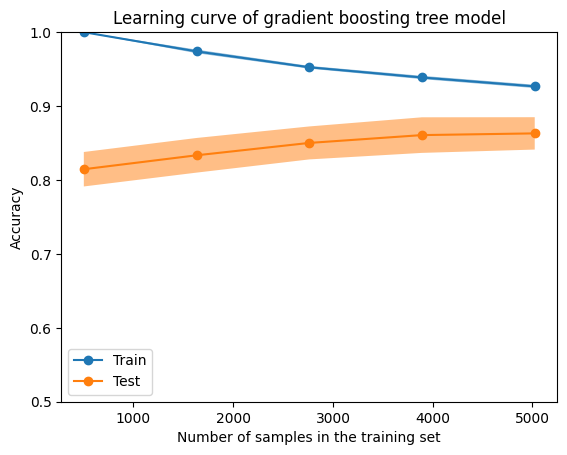

In [329]:
plt.figure()
LearningCurveDisplay.from_estimator(
    gbt,
    X_train,
    y_train,
    scoring="accuracy",
    score_name="Accuracy",
    line_kw={"marker": "o"},
    cv=30,
    n_jobs=-1,
)
plt.title(f"Learning curve of gradient boosting tree model")
plt.ylim((0.5, 1))
plt.show()

As seen on the plot, the testing curve seems to stabilize and so does the training curve. There doesn't seem to be any overfitting as the testing score is ~8\% off from the training score and both curves stabilize.

## Interpretability with SHAP (2h)

- Plot the feature importance (gain and cover) from the XGBoost model. What can you conclude?

In [330]:
# Complete this cell with your code

- Use SHAP's `TreeExplainer` to compute feature importance (Shapley values). Do you see any difference with XGBoost's feature importances?
- Produce different plots to analyze Shapley values: 
  - A bar plot that summarizes the mean absolute value of each feature.
  - A beeswarm plot that shows the shapley value for every sample and every feature.
  - A [heatmap plot](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) that indicates how different feature patterns influence the model's output.
- Based on the above results, what makes a wine 'good' or 'bad'?

In [331]:
# Complete this cell with your code

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.
- How does that modify your perspective on what makes a good or bad wine?

In [332]:
# Complete this cell with your code

- Search for literature or resources that provide indications of the chemical structure of good or poor wines. Do your findings match these resources? 

### Analyze a few bad wines, and try to see how to make them better

Pick some of the worst wines, and try to see what make them so bad. Check out [`shap.plots.heatmap`](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) for some visual tool to do this.

How would you go about improving them?

In [333]:
# Complete this cell with your code

# Wrap-up and conclusion

As wrap-up, explain what are your key findings, and make 3 recommendations to the wine maker on how to improve the wines for next year. How confident are you that making these changes will lead to better wines? Explain in simple terms to the winemaker the limitations of your approach in terms of capturing causality.